<a href="https://colab.research.google.com/github/stswee/ECE219/blob/main/ECE219_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [18]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

# Set random seeds
np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# Load in dataset
df = pd.read_csv("Project1-ClassificationDataset.csv")
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,'Personalize Your NBA App Experience for the '...,'Personalize Your NBA App Experience for the '...,"['original', 'content', 'live', 'slate', 'game...",NaN,['Official Release'],https://www.nba.com/news/nba-app-new-features-...,basketball,sports
1,'Mike Will attends the Pre-GRAMMY Gala and GRA...,'Mike WiLL Made-It has secured a partnership w...,"['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...",2023-10-18 16:22:29+00:00,['Marc Griffin'],https://www.vibe.com/news/entertainment/mike-w...,basketball,sports
2,'The Golden State Warriors are struggling to f...,'The Golden State Warriors are struggling to f...,"['insider', 'york', 'thing', 'nbc', 'tag', 'nb...",NaN,[],https://www.nbcnewyork.com/tag/featured-nba/,basketball,sports
3,"'On Nov. 28, the NBA and Nike will collaborate...","'On Nov. 28, the NBA and Nike will collaborate...","['watch', 'telecast', 'ultimate', 'membership'...",NaN,['Official Release'],https://www.nba.com/news/watch-nba-games-ultim...,basketball,sports
4,'The NBA announced additions and innovations t...,'The NBA announced additions and innovations t...,"['experience', 'bring', 'media', 'crennan', 'n...",2023-10-17 12:00:17+00:00,"['Chris Novak', 'About Chris Novak']",https://awfulannouncing.com/tech/nba-app-2023-...,basketball,sports


## Geting familiar with the dataset

### Question 1

In [3]:
# Overview
numrows = df.shape[0]
numcols = df.shape[1]

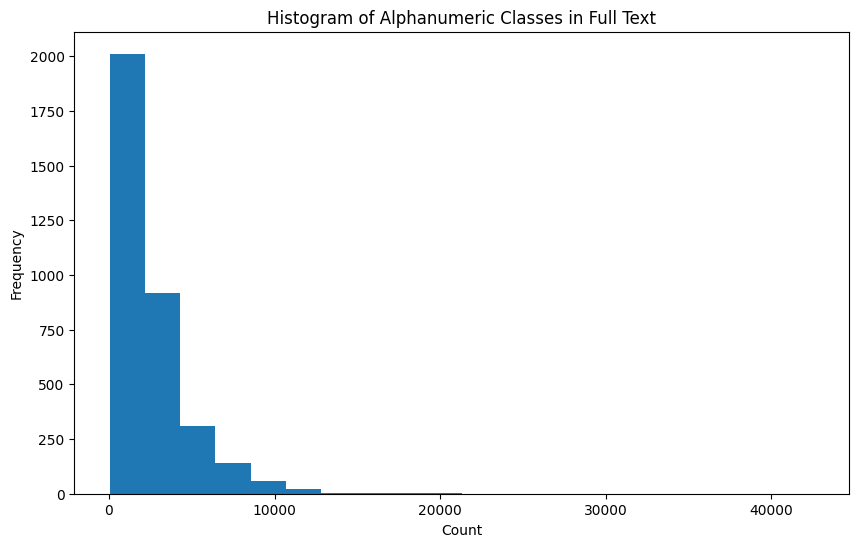

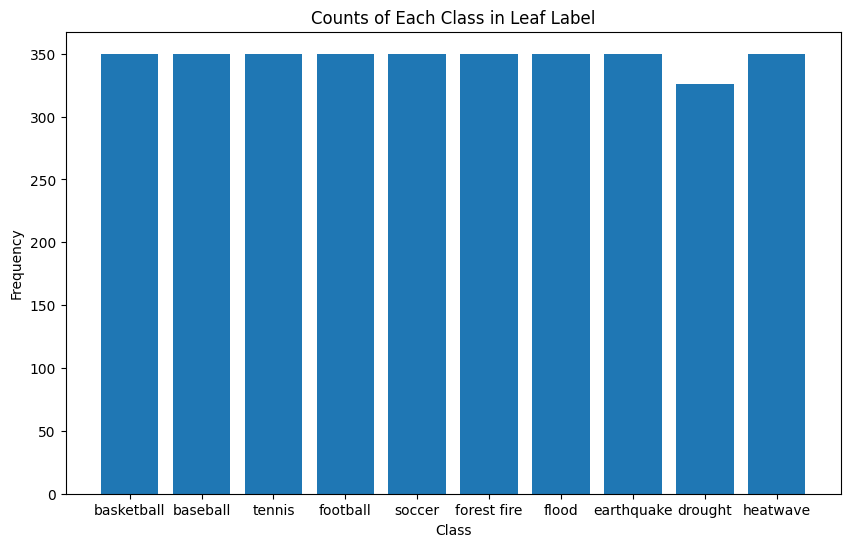

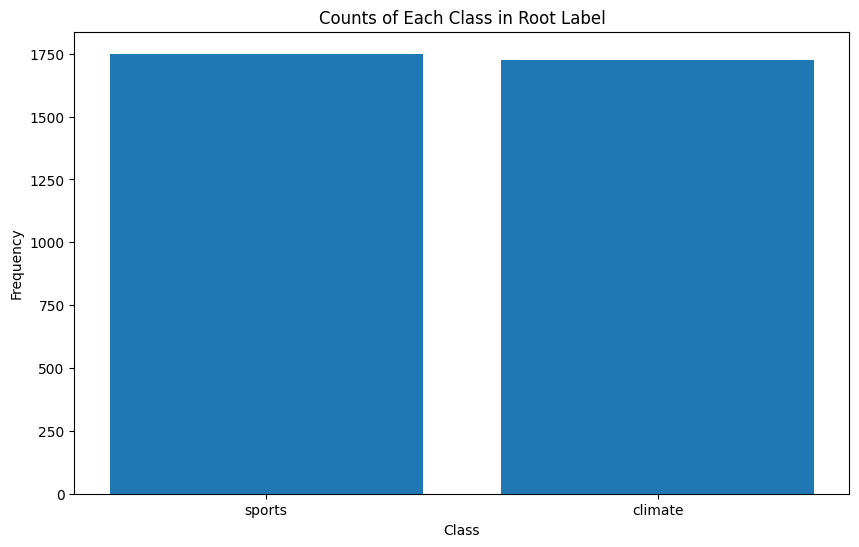

In [4]:
# Histograms
def count_alphanumeric(text = str) -> int:
  """
  Counts the number of alphanumeric characters in a string.

  Parameters
  ----------
  text : str
    The string to count the alphanumeric characters in.

  Returns
  -------
  int
    The number of alphanumeric characters in the string.
  """
  count = 0
  for char in text:
    if char.isalnum():
      count += 1
  return count

def count_classes(df = pd.DataFrame, col = str) -> list:
  """
  Counts the number of classes in a column of a dataframe.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to count the classes in.
  col : str
    The column to count the classes in.

  Returns
  -------
  2 lists
    A list of classes and a list of the counts of classes in the column.
  """
  classes = df[col].unique()
  counts = []
  for unique_class in classes:
    counts.append(df[col].str.contains(unique_class).sum())
  return classes, counts

# Keep track of counts of alphanumeric characters
count_alphanumeric_full_text = []
for text in df['full_text']:
  count_alphanumeric_full_text.append(count_alphanumeric(text))

# Keep track of counts of each class
classes_leaf_label, count_classes_leaf_label = count_classes(df, 'leaf_label')
classes_root_label, count_classes_root_label = count_classes(df, 'root_label')

# Histogram of alphanumeric characters
plt.figure(figsize=(10, 6))
plt.hist(count_alphanumeric_full_text, bins = 20)
plt.title('Histogram of Alphanumeric Classes in Full Text')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

# Histogram of counts of each class in leaf_label
plt.figure(figsize=(10, 6))
plt.bar(classes_leaf_label, count_classes_leaf_label)
plt.title('Counts of Each Class in Leaf Label')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Histogram of counts of each class in root_label
plt.figure(figsize=(10, 6))
plt.bar(classes_root_label, count_classes_root_label)
plt.title('Counts of Each Class in Root Label')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

TODO:
Some qualitative interpretation...

## Binary Classification

### 1. Splitting the entire dataset into training and testing data

In [5]:
# Set seeds
np.random.seed(42)
random.seed(42)

# Split dataset
train, test = train_test_split(df[["full_text", "root_label"]], test_size = 0.2)

### Question 2

In [6]:
# Count number of rows in train and test
num_train = train.shape[0]
num_test = test.shape[0]

# Display results
print("Number of rows in train:", num_train)
print("Number of rows in test:", num_test)


Number of rows in train: 2780
Number of rows in test: 696


### 2. Feature Extraction

### Question 3

In [16]:
def clean(text) -> str:
  """
  Processes the text based on rules.

  Parameters
  ----------
  text : str
    The string to process.

  Returns
  -------
  str
    The processed string.
  """
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

def remove_stopwords(df = pd.DataFrame, col = str) -> pd.DataFrame:
  """
  Removes stopwords from the text.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to remove stopwords from.
  col : str
    The column to remove stopwords from.

  Returns
  -------
  pd.DataFrame
    The dataframe with stopwords removed.
  """

  # Initialize CountVectorizer
  count_vectorizer = CountVectorizer(stop_words = 'english', min_df = 3)

  # Fit and transform data
  count_vectorizer.fit_transform(df[col])

  # Remove stopwords
  stop_words = count_vectorizer.get_stop_words()
  df = df[col].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words]))
  return df

def remove_numbers(df = pd.DataFrame, col = str) -> pd.DataFrame:
  """
  Removes numbers from the text.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to remove numbers from.
  col : str
    The column to remove numbers from.

  Returns
  -------
  pd.DataFrame
    The dataframe with numbers removed.
  """

  # Remove numbers
  df[col] = df[col].apply(lambda x: re.sub(r'\b\d+\b', '', x))
  return df

def remove_punctuation(df = pd.DataFrame, col = str) -> pd.DataFrame:
  """
  Remove punctuation from the text

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to remove punctuation from.
  col : str
    The column to remove punctuation from.

  Returns
  -------
  pd.DataFrame
    The dataframe with punctuation removed.
  """

  # Use translate to remove punctuation
  translator = str.maketrans('', '', string.punctuation)
  df[col] = df[col].apply(lambda x: x.translate(translator))
  return df

def lemmatize(df = pd.DataFrame, col = str) -> pd.DataFrame:
  """
  Lemmatizes the text.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to lemmatize.
  col : str
    The column to lemmatize.

  Returns
  -------
  pd.DataFrame
    The dataframe after lemmatization.
  """

  # Initialize lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Perform lemmatization
  df[col] = df[col].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
  return df


In [19]:
# Clean data sample
# Apply cleaning function
X_train = train['full_text'].apply(clean).to_frame()
X_test = test['full_text'].apply(clean).to_frame()

### The order of the following can be changed as needed

# Remove punctuation
X_train = remove_punctuation(X_train, 'full_text')
X_test = remove_punctuation(X_test, 'full_text')

# Remove numbers
X_train = remove_numbers(X_train, 'full_text')
X_test = remove_numbers(X_test, 'full_text')

# Remove stopwords
X_train = remove_stopwords(X_train, 'full_text').to_frame()
X_test = remove_stopwords(X_test, 'full_text').to_frame()

# Perform lemmatization
X_train = lemmatize(X_train, 'full_text')
X_test = lemmatize(X_test, 'full_text')

In [20]:
X_train.head()

,full_text
2677,fourday aftershock economic impact million two...
1204,cbs essential created independently cbs news e...
2955,moderatetosevere drought likely continue expan...
2266,colleen flood longtime coowner trey tavern pou...
611,washington traffic saved life yeah good baseba...



**Pros and Cons of lemmatization vs. stemming**

The advantage of lemmatization is that it accounts for context and is more robust by using morphological information. This allows lemmatization to be relatively more accurate. Stemming takes a simpler approach by removing suffixes (i.e. the rightmost letters) to find the root word. While this approach is simpler and allows stemming to be faster than lemmatization, stemming is generally less accurate.

In short, the tradeoff between between lemmatization and stemming is between speed (stemming preferred) and accuracy (lemmatization preferred).

**Changing minimum document frequency**

Increasing the minimum document frequency means that words will have to appear in more documents to be kept. This higher threshold leads to fewer words being kept, ultimately decreasing the number of columns in the TF-IDF matrix.

**Before and after lemmatizing**

Performing additional preprocessing steps before or after lemmatizing comes down to choosing between retaining context and computation time. Removing stopwords, punctuations, and numbers before lemmatizing will require less computational overhead using lemmatizing. Keeping stopwords, punctuations, and numbers will allows context to be retained for lemmatization. In general, if stopwords, punctuations, and numbers contribute little to the context of the document with respect to the classes the documents are a part of, then it may be fine to remove them prior to lemmatization.

In the context of this project, we choose to perform lemmatization after removing stopwords, punctuations, and numbers. We assume that stopwords, punctuations, and numbers contribute little to the context (i.e. they do not help distinguish between whether a document is about sports or climate).

